In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import (cross_val_score, RepeatedStratifiedKFold,
    GridSearchCV, train_test_split)
from sklearn.metrics import (f1_score, classification_report, accuracy_score,
    confusion_matrix)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from paths import RAW_DIR, STAGE_DIR
from display import cdisplay

In [3]:
data = pd.read_csv(RAW_DIR / 'heart_disease.csv')
data_univariate = pd.read_parquet(STAGE_DIR / 'selection' / 'univariate.parquet')
data_multivariate = pd.read_parquet(STAGE_DIR / 'selection' / 'multivariate.parquet')

In [4]:
TARGET = 'HeartDiseaseorAttack'

# All features

Train with all the variables and observations.

In [ ]:
train_df, test_df = train_test_split(data)

X = data.drop(TARGET, axis=1)

y_train, y_test = train_df[TARGET], test_df[TARGET]
X_train, X_test = train_df.drop(TARGET, axis=1), test_df.drop(TARGET, axis=1)

## LinearDiscriminantAnalysis

In [5]:
discriminant_analysis = LinearDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(
    discriminant_analysis, X_train, y_train,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.902 (0.001)


In [6]:
discriminant_analysis = discriminant_analysis.fit(X_train, y_train)
data['proba'] = discriminant_analysis.predict_proba(X)[:, 1]
data['log_proba'] = discriminant_analysis.predict_log_proba(X)[:, 1]

In [7]:
data['log_proba'].describe()

count    253680.000000
mean         -3.234809
std           1.324990
min          -7.072861
25%          -4.249826
50%          -3.344788
75%          -2.321447
max          -0.014236
Name: log_proba, dtype: float64

In [8]:
data['proba'].describe()

count    253680.000000
mean          0.097014
std           0.160279
min           0.000848
25%           0.014267
50%           0.035268
75%           0.098131
max           0.985865
Name: proba, dtype: float64

<AxesSubplot: xlabel='log_proba', ylabel='Count'>

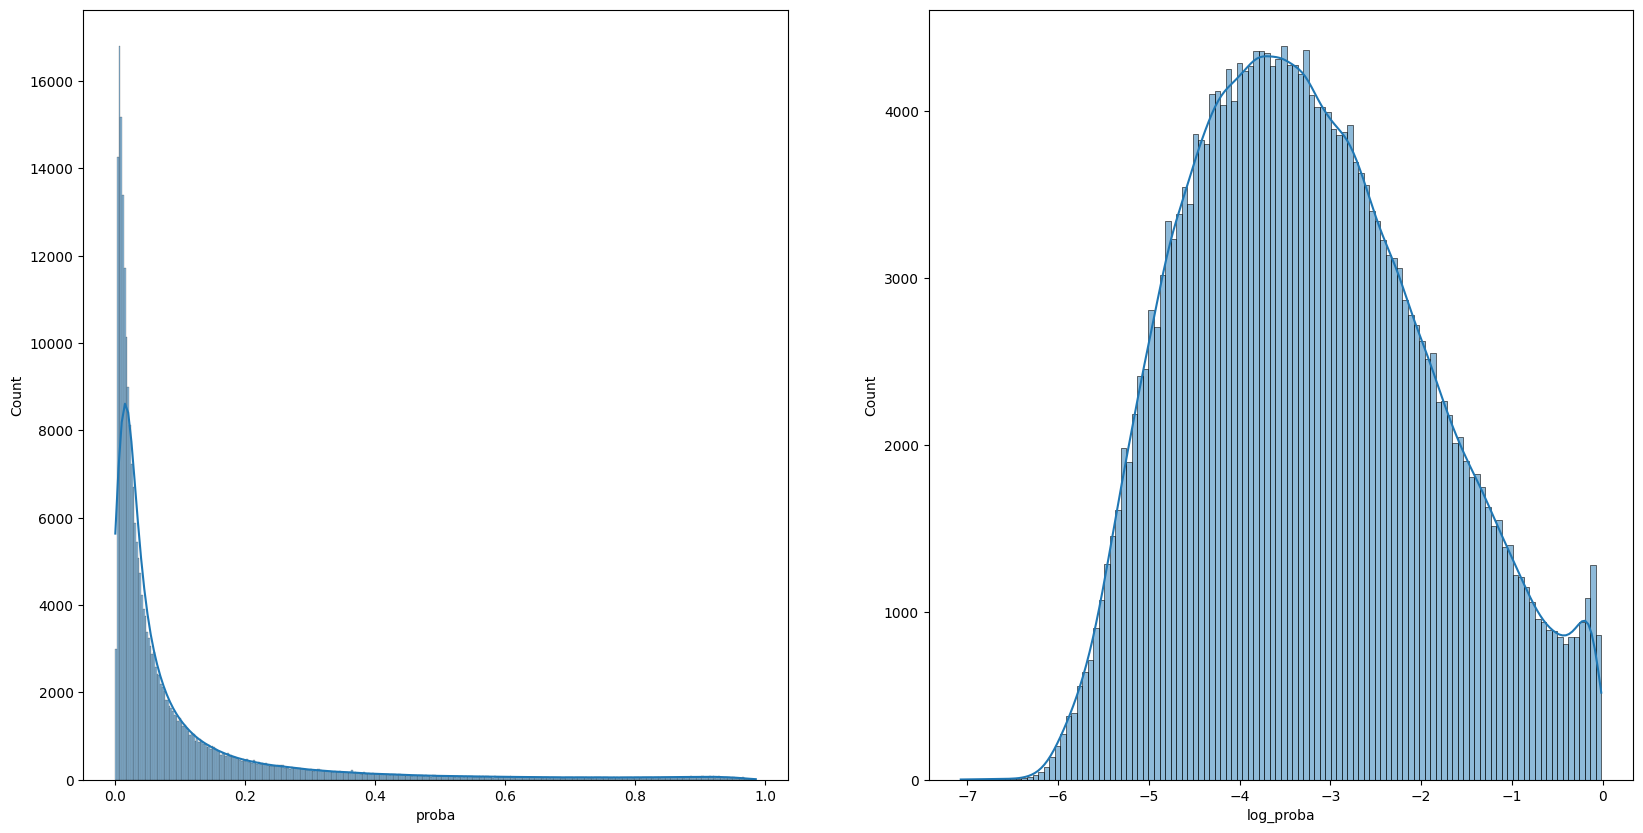

In [9]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(data['proba'], kde=True, ax=ax[0])
sns.histplot(data['log_proba'], kde=True, ax=ax[1])

## Hyperparameter tunning for LinearDiscriminantAnalysis

In [10]:
grid_shrinkage = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': np.arange(0, 1, 0.01),

}

search_shrinkage = GridSearchCV(
    discriminant_analysis,
    grid_shrinkage,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)
results_shrinkage = search_shrinkage.fit(X_train, y_train)

In [11]:
# summarize
print('Mean Accuracy: %.3f' % results_shrinkage.best_score_)
print('Config: %s' % results_shrinkage.best_params_)

Mean Accuracy: 0.907
Config: {'shrinkage': 0.01, 'solver': 'lsqr'}


In [12]:
grid_solver = {
    'solver': ['svd', 'lsqr', 'eigen'],
}

search_solver = GridSearchCV(
    discriminant_analysis,
    grid_solver,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)
results_solver = search_solver.fit(X_train, y_train)

In [13]:
# summarize
print('Mean Accuracy: %.3f' % results_solver.best_score_)
print('Config: %s' % results_solver.best_params_)

Mean Accuracy: 0.902
Config: {'solver': 'svd'}


This analysis suggest that it's better to use the solver `lqrs` with shrinkage 0.01, given that the accuracy metric improve with those parameters.

# Univariate features

In [ ]:
train_univariate_df, test_univariate_df = train_test_split(data_univariate)

X_univariate = data_univariate.drop(TARGET, axis=1)

y_univariate_train, y_univariate_test = train_univariate_df[TARGET], test_univariate_df[TARGET]
X_univariate_train, X_univariate_test = train_univariate_df.drop(TARGET, axis=1), test_univariate_df.drop(TARGET, axis=1)

In [14]:
discriminant_analysis_univariate = LinearDiscriminantAnalysis()
cv_univariate = RepeatedStratifiedKFold(
    n_splits=10, n_repeats=3, random_state=1)
scores_univariate = cross_val_score(
    discriminant_analysis, X_univariate_train, y_univariate_train,
    scoring='accuracy',
    cv=cv_univariate,
    n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores_univariate), np.std(scores_univariate)))

Mean Accuracy: 0.906 (0.000)


In [15]:
discriminant_analysis_univariate = discriminant_analysis_univariate.fit(X_univariate_train, y_univariate_train)
data_univariate['proba'] = discriminant_analysis_univariate.predict_proba(X_univariate)[:, 1]
data_univariate['log_proba'] = discriminant_analysis_univariate.predict_log_proba(X_univariate)[:, 1]

In [16]:
data_univariate['log_proba'].describe()

count    253680.000000
mean         -2.985520
std           1.188830
min          -5.967567
25%          -3.889002
50%          -2.956911
75%          -2.056656
max          -0.396362
Name: log_proba, dtype: float64

In [17]:
data_univariate['proba'].describe()

count    253680.000000
mean          0.095142
std           0.109548
min           0.002560
25%           0.020466
50%           0.051979
75%           0.127881
max           0.672763
Name: proba, dtype: float64

<AxesSubplot: xlabel='log_proba', ylabel='Count'>

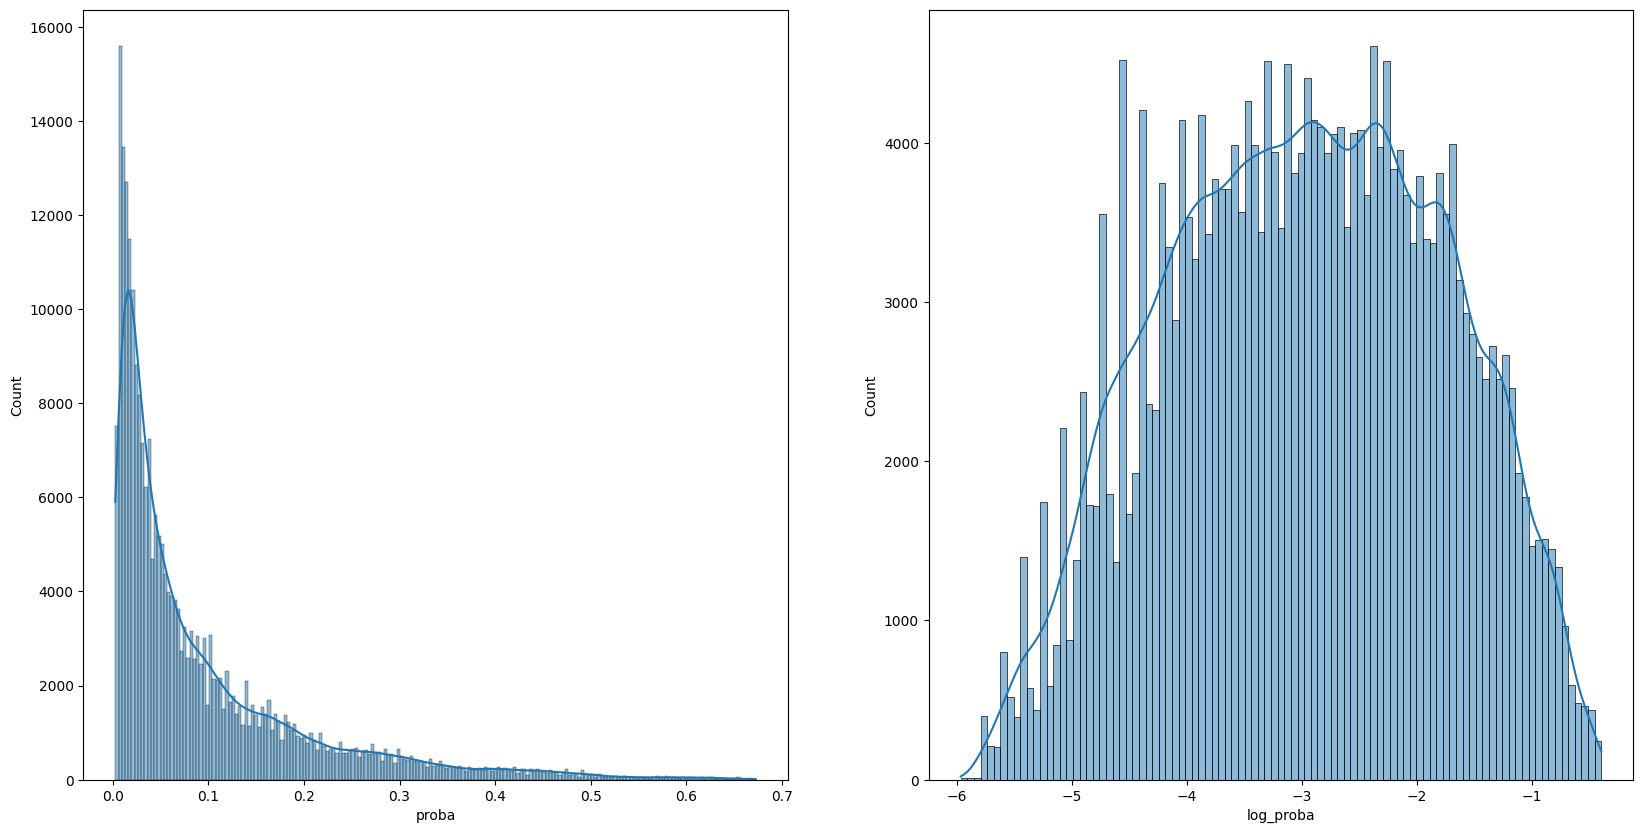

In [18]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(data_univariate['proba'], kde=True, ax=ax[0])
sns.histplot(data_univariate['log_proba'], kde=True, ax=ax[1])

## Hyperparameter tunning for LinearDiscriminantAnalysis

In [19]:
grid_shrinkage_univariate = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': np.arange(0, 1, 0.01),
}

search_shrinkage_univariate = GridSearchCV(
    discriminant_analysis_univariate,
    grid_shrinkage_univariate,
    scoring='accuracy',
    cv=cv_univariate,
    n_jobs=-1
)
results_shrinkage_univariate = search_shrinkage_univariate.fit(X_univariate_train, y_univariate_train)

In [20]:
# summarize
print('Mean Accuracy: %.3f' % results_shrinkage_univariate.best_score_)
print('Config: %s' % results_shrinkage_univariate.best_params_)

Mean Accuracy: 0.906
Config: {'shrinkage': 0.0, 'solver': 'lsqr'}


In [21]:
grid_solver_univariate = {
    'solver': ['svd', 'lsqr', 'eigen'],
}

search_solver_univariate = GridSearchCV(
    discriminant_analysis_univariate,
    grid_solver_univariate,
    scoring='accuracy',
    cv=cv_univariate,
    n_jobs=-1
)
results_solver_univariate = search_solver_univariate.fit(X_univariate_train, y_univariate_train)

In [22]:
# summarize
print('Mean Accuracy: %.3f' % results_solver_univariate.best_score_)
print('Config: %s' % results_solver_univariate.best_params_)

Mean Accuracy: 0.906
Config: {'solver': 'svd'}


# Multivariate features

In [11]:
train_multivariate_df, test_multivariate_df = train_test_split(data_multivariate)

y_multivariate = data_multivariate[TARGET]
X_multivariate = data_multivariate.drop(TARGET, axis=1)

y_multivariate_train, y_multivariate_test = train_multivariate_df[TARGET], test_multivariate_df[TARGET]
X_multivariate_train, X_multivariate_test = train_multivariate_df.drop(TARGET, axis=1), test_multivariate_df.drop(TARGET, axis=1)

# Oversample train data to solve imbalance
# over_sampler = RandomOverSampler(random_state=42)
# X_multivariate_train, y_multivariate_train,  = over_sampler.fit_resample(X_multivariate_train, y_multivariate_train)

# Undersample train data to solve imbalance
under_sampler = RandomUnderSampler(random_state=42)
X_multivariate_train, y_multivariate_train,  = under_sampler.fit_resample(X_multivariate_train, y_multivariate_train)

## Simple model

In [7]:
discriminant_analysis_multivariate = LinearDiscriminantAnalysis()
cv_multivariate = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_multivariate = cross_val_score(
    discriminant_analysis_multivariate, X_multivariate_train, y_multivariate_train,
    scoring='accuracy',
    cv=cv_multivariate,
    n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores_multivariate), np.std(scores_multivariate)))

Mean Accuracy: 0.902 (0.001)


In [24]:
discriminant_analysis_multivariate = discriminant_analysis_multivariate.fit(X_multivariate_train, y_multivariate_train)
data_multivariate['proba'] = discriminant_analysis_multivariate.predict_proba(X_multivariate)[:, 1]
data_multivariate['log_proba'] = discriminant_analysis_multivariate.predict_log_proba(X_multivariate)[:, 1]

In [25]:
data_multivariate['log_proba'].describe()

count    253680.000000
mean         -3.203176
std           1.306614
min          -6.499824
25%          -4.158694
50%          -3.273160
75%          -2.301636
max          -0.030076
Name: log_proba, dtype: float64

In [26]:
data_multivariate['proba'].describe()

count    253680.000000
mean          0.096083
std           0.155727
min           0.001504
25%           0.015628
50%           0.037887
75%           0.100095
max           0.970371
Name: proba, dtype: float64

<AxesSubplot: xlabel='log_proba', ylabel='Count'>

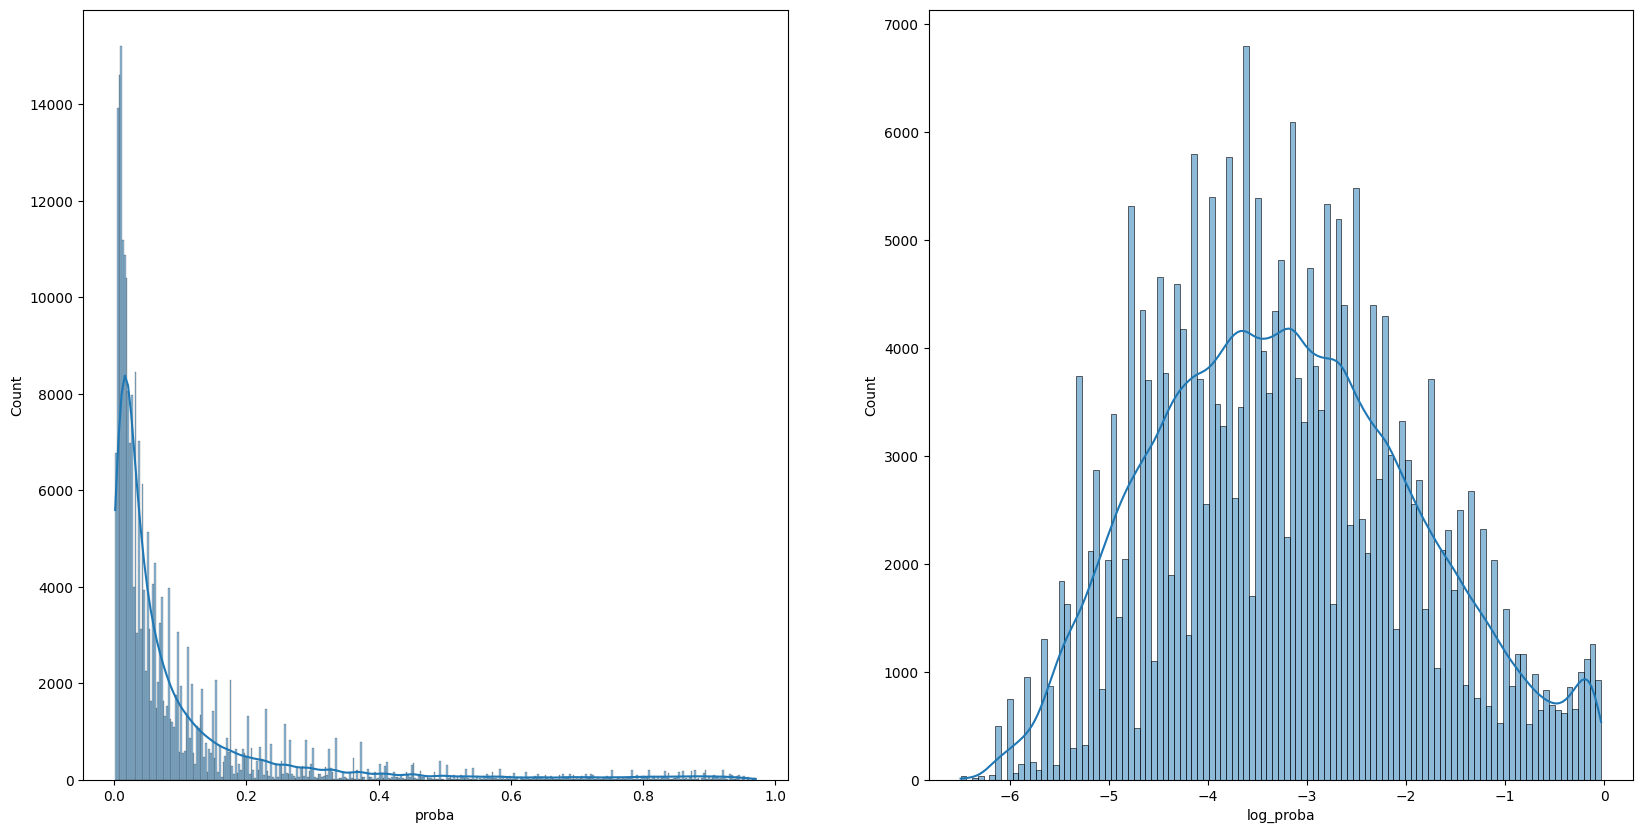

In [27]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(data_multivariate['proba'], kde=True, ax=ax[0])
sns.histplot(data_multivariate['log_proba'], kde=True, ax=ax[1])

## Hyperparameter tunning for LinearDiscriminantAnalysis

In [6]:
discriminant_analysis_multivariate = LinearDiscriminantAnalysis()
cv_multivariate = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_shrinkage_multivariate = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': np.arange(0, 1, 0.01),
}

search_shrinkage_multivariate = GridSearchCV(
    discriminant_analysis_multivariate,
    grid_shrinkage_multivariate,
    scoring='accuracy',
    cv=cv_multivariate,
    n_jobs=-1
)
results_shrinkage_multivariate = search_shrinkage_multivariate.fit(X_multivariate_train, y_multivariate_train)

In [7]:
# summarize
print('Mean Accuracy: %.3f' % results_shrinkage_multivariate.best_score_)
print('Config: %s' % results_shrinkage_multivariate.best_params_)

Mean Accuracy: 0.765
Config: {'shrinkage': 0.0, 'solver': 'lsqr'}


In [8]:
y_out_sample = results_shrinkage_multivariate.predict(X_multivariate_test)
y_test_predict = results_shrinkage_multivariate.predict(X_multivariate)

In [9]:
print(classification_report(y_multivariate_test, y_out_sample))

              precision    recall  f1-score   support

         0.0       0.97      0.73      0.84     57480
         1.0       0.24      0.82      0.37      5940

    accuracy                           0.74     63420
   macro avg       0.61      0.77      0.60     63420
weighted avg       0.91      0.74      0.79     63420



In [52]:
conf = pd.DataFrame(
  confusion_matrix(y_multivariate_test, y_out_sample),
  columns = ['Predicted 0', 'Predicted 1'],
  index = ['True 0', 'True 1']
)
conf

,Predicted 0,Predicted 1
True 0,42023,15463
True 1,1195,4739


In [13]:
print(classification_report(y_multivariate, y_test_predict))

              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83    229787
         1.0       0.24      0.81      0.37     23893

    accuracy                           0.74    253680
   macro avg       0.61      0.77      0.60    253680
weighted avg       0.90      0.74      0.79    253680



In [14]:
conf = pd.DataFrame(
  confusion_matrix(y_multivariate, y_test_predict),
  columns = ['Predicted 0', 'Predicted 1'],
  index = ['True 0', 'True 1']
)
conf

,Predicted 0,Predicted 1
True 0,167806,61981
True 1,4591,19302


In [16]:
grid_solver_multivariate = {
    'solver': ['svd', 'lsqr', 'eigen'],
}

search_solver_multivariate = GridSearchCV(
    discriminant_analysis_multivariate,
    grid_solver_multivariate,
    scoring='accuracy',
    cv=cv_multivariate,
    n_jobs=-1
)
results_solver_multivariate = search_solver_multivariate.fit(X_multivariate_train, y_multivariate_train)

In [17]:
# summarize
print('Mean Accuracy: %.3f' % results_solver_multivariate.best_score_)
print('Config: %s' % results_solver_multivariate.best_params_)

Mean Accuracy: 0.769
Config: {'solver': 'svd'}


# Save predictions

In [33]:
data.to_parquet(STAGE_DIR / 'process' / 'predictions.parquet')
data_univariate.to_parquet(STAGE_DIR / 'process' / 'predictions_univariate.parquet')
data_multivariate.to_parquet(STAGE_DIR / 'process' / 'predictions_multivariate.parquet')